### Predictive Modeling using Pokemon Dataset

This notebook deals with the Pokemon dataset which containes the description of 100 Pokemons - like their name, HP, attacks, defense.

A predictive multinomial model is built using spark and the model is evaluated

#### Loading the required Spark Libraries

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

%matplotlib inline

#### Initializing the spark environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

#### Reading Data from S3

In [3]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'mr6rx/Pokemon.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pandas_df = pd.read_csv(data_location)

pandas_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


#### Pre-processing

In [4]:
pandas_df = pandas_df.fillna(" ")
pandas_df.columns = pandas_df.columns.str.replace(" |[.]","_")

In [5]:
df = sqlc.createDataFrame(pandas_df)

#### Writing parquet to s3

In [8]:
parquetPath = '/home/ec2-user/SageMaker/mr6rx-pqt'
# df.write.parquet(parquetPath)

In [9]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    print('copying {} to {}'.format(parquetPath+'/'+f,"mr6rx/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "mr6rx/pqt/"+f)

copying /home/ec2-user/SageMaker/mr6rx-pqt/.part-00000-fb3ade53-1727-48e5-8d07-76dc000fffa7-c000.snappy.parquet.crc to mr6rx/.part-00000-fb3ade53-1727-48e5-8d07-76dc000fffa7-c000.snappy.parquet.crc
copying /home/ec2-user/SageMaker/mr6rx-pqt/._SUCCESS.crc to mr6rx/._SUCCESS.crc
copying /home/ec2-user/SageMaker/mr6rx-pqt/part-00000-fb3ade53-1727-48e5-8d07-76dc000fffa7-c000.snappy.parquet to mr6rx/part-00000-fb3ade53-1727-48e5-8d07-76dc000fffa7-c000.snappy.parquet
copying /home/ec2-user/SageMaker/mr6rx-pqt/_SUCCESS to mr6rx/_SUCCESS


### Getting Spark dataframe from Parquet

In [36]:
df = sqlc.read.parquet(parquetPath)

In [12]:
display(df)

DataFrame[#: bigint, Name: string, Type_1: string, Type_2: string, Total: bigint, HP: bigint, Attack: bigint, Defense: bigint, Sp__Atk: bigint, Sp__Def: bigint, Speed: bigint, Generation: bigint, Legendary: boolean]

In [13]:
df.printSchema()

root
 |-- #: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Type_1: string (nullable = true)
 |-- Type_2: string (nullable = true)
 |-- Total: long (nullable = true)
 |-- HP: long (nullable = true)
 |-- Attack: long (nullable = true)
 |-- Defense: long (nullable = true)
 |-- Sp__Atk: long (nullable = true)
 |-- Sp__Def: long (nullable = true)
 |-- Speed: long (nullable = true)
 |-- Generation: long (nullable = true)
 |-- Legendary: boolean (nullable = true)



## Performing some EDA on the dataset

In [38]:
df

DataFrame[#: bigint, Name: string, Type_1: string, Type_2: string, Total: bigint, HP: bigint, Attack: bigint, Defense: bigint, Sp__Atk: bigint, Sp__Def: bigint, Speed: bigint, Generation: bigint, Legendary: boolean]

In [50]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'bigint']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
#,800,362.81375,208.34379756406656,1,721
Total,800,435.1025,119.96303975551908,180,780
HP,800,69.25875,25.534669032332076,1,255
Attack,800,79.00125,32.45736586949845,5,190
Defense,800,73.8425,31.183500559332924,5,230
Sp__Atk,800,72.82,32.7222941688016,10,194
Sp__Def,800,71.9025,27.82891579711746,20,230
Speed,800,68.2775,29.060473717161447,5,180
Generation,800,3.32375,1.6612904004849451,1,6


(array([166.,   0., 106.,   0., 160.,   0., 121.,   0., 165.,  82.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

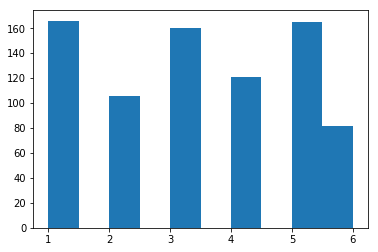

In [51]:
import matplotlib.pyplot as plt
plt.hist(df.toPandas().Generation)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


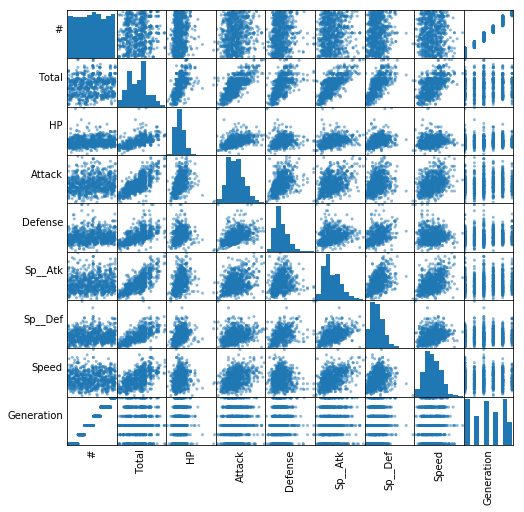

In [53]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [10]:
print("Pearson's r(HP,Attack) = {}".format(df.corr("Total", "Sp__Def")))
print("Pearson's r(HP,Total) = {}".format(df.corr("Total", "HP")))
print("Pearson's r(Defense,Special Defence) = {}".format(df.corr("Defense", "Sp__Def")))

Pearson's r(HP,Attack) = 0.7176094700519225
Pearson's r(HP,Total) = 0.6187483543135462
Pearson's r(Defense,Special Defence) = 0.5107465890885571


### Preparing data for the Model

In [12]:
df_model = df.select("Total","HP","Attack","Defense","Sp__Atk","Sp__Def","Speed","Generation")

In [30]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df_model.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 640, test set N = 160


### Vectorization

In [31]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [32]:
# vectorize the data frame features
assembler = VectorAssembler(
    inputCols=df_model.columns[:7],
    outputCol="features")

trainingVDF = assembler.transform(trainingDF)
testVDF = assembler.transform(testDF)

In [33]:
# define label columns 
trainingVDF = trainingVDF.withColumnRenamed("Generation", "label")
testVDF = testVDF.withColumnRenamed("Generation", "label")

### Applying Maching Learning Models

### Multinomial Logistic Regression

In [34]:
#from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.classification import LogisticRegression

In [35]:
lr = LogisticRegression(maxIter=10, regParam=0.3,\
                        elasticNetParam=0.8,family="multinomial")

# Fit the model
lrModel = lr.fit(trainingVDF)

In [36]:
#### Predicting the values for test dataset
predictionsAndLabelsDF = lrModel.transform(testVDF)

print(predictionsAndLabelsDF.\
      orderBy(predictionsAndLabelsDF.label.desc()).take(1))

[Row(Total=213, HP=45, Attack=22, Defense=60, Sp__Atk=27, Sp__Def=30, Speed=29, label=6, features=DenseVector([213.0, 45.0, 22.0, 60.0, 27.0, 30.0, 29.0]), rawPrediction=DenseVector([-5.9777, 1.2969, 0.7765, 1.2088, 1.0306, 1.2088, 0.4561]), probability=DenseVector([0.0001, 0.2163, 0.1285, 0.198, 0.1657, 0.198, 0.0933]), prediction=1.0)]


In [37]:
print("Coefficients: \n" + str(lrModel.coefficientMatrix))
print("Intercept: " + str(lrModel.interceptVector))

Coefficients: 
7 X 7 CSCMatrix

Intercept: [-5.977665649992222,1.2968737052656434,0.7765090477209668,1.2087677537105126,1.0306339696508011,1.2087677537105128,0.45611341993378496]


### Model Evaluation

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [39]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")


accuracy = evaluator.evaluate(predictionsAndLabelsDF)
print("Test Accuracy = %g " % (accuracy))

Test Accuracy = 0.175 


In [40]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")


f1 = evaluator.evaluate(predictionsAndLabelsDF)
print("Test F1 = %g " % (f1))

Test F1 = 0.0521277 
